# (PART2) 튼튼한 GAN 만들기

## (CHAPTER5) GAN 개념  

### 이미지 생성하기  
백쿼리(backquery)를 통해 생성된 이미지의 특징  
- 같은 원핫 인코딩 백터에서의 같은 결과  
- 해당 레이블의 트레이닝 이미지들의 평균적인 이미지가 생성됨  
  
네트워크 모델을 이용하여 얻어내고 싶은 이상적인 결과  
- 서로 다른 이미지들을 만들어 내기  
- 트레이닝 이미질과 같은 퀄리티의 이미지  

But, 간단한 백쿼리로는 이와 같은 목적 달성 어려움  

### 적대적 훈련  
뉴럴넷 두개를 사용.  
이들을 각각 생성기와 판별기  
"어떻게 훈련을 하느냐?" # 이 부분이 GAN의 핵심  
  
<트레이닝 포인트(by loss function)>  
* 판별기를 무사히 속이면 생성기에 보상을 준다  
* 판별기가 정상적으로 판별하면 생성기에 벌을 준다  
  
  
<b>GAN 트레이닝의 장점</b>  
진짜 이미지를 판단하기 위해서 어떤 방식을 따르고  
어떤 손실함수를 거쳐야 하는지를 설정하지 않아도 됨  
생성에 관련된 handcraft loss function이 아님  
단순한 기존 loss의 조합으로 구현 가능함  

### GAN 훈련  
제대로 훈련하기 위해서는 두개의 NN을 동시에 훈련시키면서  
밸런스도 유지되도록(비슷한 수준으로 훈련되도록) 유도해야 함  
  
단계를 총 3개로 나누어 설명  
<b><span style="color:red">1단계:</span></b> 판별기에 실제 데이터를 입력, 라벨 1으로 학습  
<b><span style="color:red">2단계:</span></b> 판별기에 생성기로부터 만들어진 페이크 데이터를 입력, 라벨 0으로 학습  
<b><span style="color:red">3단계:</span></b> 판별기에 생성기의 결과를 입력, 생성기에 결과가 1이 되도록 학습  


### 훈련하기 어려운 GAN  
실무에서는 GAN을 훈련하는 것이 굉장히 까다로움  
서로 균형이 맞춰져 있어야만 GAN이 제대로 훈련됨  

### 핵심 정리  
* <b><span style="color:red">분류는 데이터를 감소시키는 것</span></b>에서 출발함.  
    * 입력값을 줄여 클래스당 하나의 출력값을 가지도록 만드는 행위임.  
* 생성은 데이터를 확장하여 얻어내는 것.  
    * 생성적 신경망은 <b><span style="color:red">작은 수의 시드(seed)를 훨씬 큰 크기의 출력값으로 확장</span></b>하는 역할을 수행.  
* 생성적 적대 신경망은 두개의 신경망 모델을 포함함.  
    * 생성기와 판별기, 이들은 서로 적대시하도록 만들어져 있음.  
* GAN을 설계하고 훈련하는 일은 어려움.  
    * 어떤 경우에 실패하고 성공하는지 성숙하지 않음 # 지금은 모르겠음  
* 일반적인 GAN은 3단계로 파라미터 업데이트 진행.  
    1. D를 실제 데이터로 트레이닝
    2. D를 G로 생성된 데이터로 트레이닝  
    3. G가 D의 결과가 실제로 나오도록 트레이닝  

## (CHAPTER6) 단순한 1010 패턴

데이터가 항상 4자리의 digit 1010이라고 가정  
따라서, G는 4자리의 digit을 출력하고,  
D는 4자리의 digit을 입력받아 True/False를 판단하도록 설계함

In [1]:
import torch
import torch.nn as nn

import random
import pandas
import matplotlib.pyplot as plt
import numpy as np

### 실제 데이터 소스

실제 세계의 데이터에는 Noise가 있으므로,  
실제 상황과 유사한 Noise가 추가되도록  
<code>random.uniform()</code>을 이용,  
노이즈를 추가한 텐서 [1,0,1,0]을 생성

In [2]:
def generate_real():
    # real_data = torch.FloatTensor([1, 0, 1, 0])
    real_data = torch.FloatTensor(
        [
            random.uniform(0.8, 1.0),
            random.uniform(0, 0.2),
            random.uniform(0.8, 1.0),
            random.uniform(0.0, 0.2),
        ]
    )
    return real_data

generate_real()

tensor([0.9456, 0.0843, 0.9025, 0.0943])

### 판별기 만들기

D의 클래스 안에 optimizer, loss_function, tracker를 포함하도록 설계.  
activation function으로 Sigmoid를 사용,  
최종으로 나오는 값이 0~1사이의 Prob로 pred하여 <span style="color:red"><b>FAKE, REAL</b></span>을 판별하도록 설계.

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(4,3), nn.Sigmoid(), nn.Linear(3,1), nn.Sigmoid())
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0 # count epoch
        self.progress = [] # for appending loss
    

    def train(self, inputs, targets):
        """params update와 logging까지 같이 수행하는 함수

        Args:
            inputs (torch.Tensor): 데이터
            targets (torch.Tensor): 라벨
        """
        outputs = self.forward(inputs) # forward
        loss:torch.Tensor = self.loss_function(outputs, targets) # loss
        
        # appending loss
        self.counter += 1
        if  (self.counter % 10 == 0):
            self.progress.append(loss.item())
        # print info
        if (self.counter % 10000 == 0):
            print(f"counter = {self.counter}")
            

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(8,4), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))
    
    def forward(self, x):
        return self.model(x)

10 iter마다 발생하는 loss를 저장하고  
10000 iter마다 현재의 iter 개수를 print하도록 한다.  

### 판별기 테스트하기

In [4]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

generate_random(4)

tensor([0.8103, 0.1471, 0.4374, 0.9874])

counter = 10000
counter = 20000


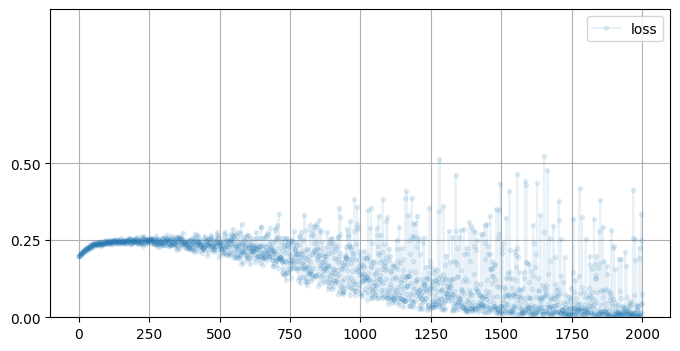

In [5]:
D = Discriminator()

for i in range(10000): # 10000번의 iter
    # 1ter마다 2번의 parameter update가 됨
    D.train(generate_real(), torch.FloatTensor([1.0])) # real data update
    D.train(generate_random(4), torch.FloatTensor([0.0])) # face data update

D.plot_progress()

학습이 진행될수록(=iter가 늘어날수록) Loss가 0으로 떨어지는 것을 확인할 수 있음.

In [6]:
# predictions
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.7828637361526489
0.07820797711610794


<code>real_data</code>를 넣었을때 1에 가까운 pred값을 가지고,  
<code>face_data</code>를 넣었을때 0에 가까운 pred값을 가지는 것을 확인할 수 있음.

### 생성기 만들기

<b>설계 고려사항</b>  
1. output은 4개의 숫자가 될 수 있도록 4개의 노드로 구현  
2. 판별기와 균형을 이룰 수 있도록 비슷한 모델 크기로 구현  

Generator와 달리 고려해야 할점  
- 파라미터의 업데이트는 판별기의 Loss로부터 backpropa되어야 한다
- G에서는 D의 classification 결과를 몰라, loss를 구할 수 없다
때문에, G의 train()에 G를 넘겨주는 방식으로 구현한다


In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(1,3),
            nn.Sigmoid(),
            nn.Linear(3,4),
            nn.Sigmoid()
        )
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0
        self.progress = []
    

    def forward(self, x):
        return self.model(x)
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(8,4), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))
    
    def train(self, D:Discriminator, inputs:torch.Tensor, targets:torch.Tensor):
        # 생성기 Fake 생성
        g_output = self.forward(inputs)
        
        # 판별기로 전달
        d_output = D.forward(g_output)
        
        # 오차 계산
        loss:torch.Tensor = D.loss_function(d_output, targets)
        
        self.counter += 1
        if self.counter %10 == 0:
            self.progress.append(loss.item())
        
        self.optimizer.zero_grad()
        loss.backward()
         # optimizer의 아규먼트에는 self(G)만 존재하므로, only 생성기 params 업데이트
        self.optimizer.step()

G가 생성한 g_output이 D의 foward에 입력됨.  
D의 판별결과 d_output으로 loss 계산됨.  
계산된 loss는 backpropa를 통하여 연결된 weight들에 전파됨.  
self.optimizer(G.optimizer)만 update가 됨.  
참고로, 이 코드의 함수안으로 전달된 D는 call by reference 방식임.

<b>Chat-GPT</b>  
파이썬에서 클래스 B 객체를 클래스 A의 함수에 넘겨주고 해당 함수 내에서 클래스 B의 인수(argument)를 변경하는 경우,  
함수가 종료된 후에도 클래스 B의 변경된 인수는 유지됩니다.  
이는 파이썬에서 객체는 "참조에 의한 전달(call by reference)" 방식으로 동작하기 때문입니다.
  
"참조에 의한 전달(call by reference)"는 함수에 인수로 객체를 전달할 때,  
실제로는 객체의 참조(메모리 주소)가 전달되는 방식을 의미합니다.  
따라서 함수 내에서 해당 객체의 상태를 변경하면, 원래 객체의 상태도 같이 변경됩니다.  
이는 클래스 B 객체를 클래스 A 함수에 전달한 경우에도 동일하게 적용됩니다.
  
간단한 예시를 통해 설명해보겠습니다:  

```
class B:
    def __init__(self, value):
        self.value = value

class A:
    def update_value(self, obj):
        obj.value += 10

b = B(5)
print(b.value)  # 출력: 5

a = A()
a.update_value(b)
print(b.value)  # 출력: 15
```  

위의 예시에서 update_value 함수는 클래스 B의 객체를 인수로 받고,  
해당 객체의 value 속성을 10 증가시킵니다.  
b 객체의 value는 15로 변경됩니다.  
이는 함수가 종료된 후에도 b 객체의 상태가 변경되어 유지되는 것을 확인할 수 있습니다.  
  
따라서, 파이썬에서 클래스 A 함수 내에서 클래스 B 객체를 변경하면  
함수가 종료된 후에도 변경된 객체의 상태가 유지되는 것은 참조에 의한 전달(call by reference)의 특성입니다.


### 생성기 결과 확인하기

In [8]:
G = Generator()
G.forward(torch.FloatTensor([0.5])), G.forward(torch.FloatTensor([0.5])).shape

(tensor([0.5285, 0.6052, 0.5789, 0.6278], grad_fn=<SigmoidBackward0>),
 torch.Size([4]))

### GAN 훈련하기

In [9]:
%%time

D = Discriminator()
G = Generator()
img_list = [] # training 중간의 G가 생성한 sample을 저장하기 위해서

ITER = 10000

for i in range(ITER):
    # 1단계: 참 샘플에 대해 판별기 훈련
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # 2단계: 거짓 샘플에 대한 판별기 훈련
    D.train(G.forward(torch.FloatTensor([0.5])).detach(),
            torch.FloatTensor([0.0]))
    '''
    << G.forward(...).detach()의 이유 >>
    D의 backward 과정에서 loss 전파를 막음.
    업데이트에서 큰 영향은 없으나,
    네트워크가 커질수록 불필요한 시간이 많이 소모됨.
    따라서 효율성을 위해서 loss전파가 일어나지 않도록 함.
    
    
    '''
    
    # 3단계: 생성기 훈련
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    '''
    D에서의 loss가 G까지 흘러야 하므로 [0.5] detach 하지 않음.
    '''
    if (i%1000 == 0):
        img_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())
            

counter = 10000
counter = 20000
CPU times: user 4.61 s, sys: 35.3 ms, total: 4.64 s
Wall time: 4.64 s


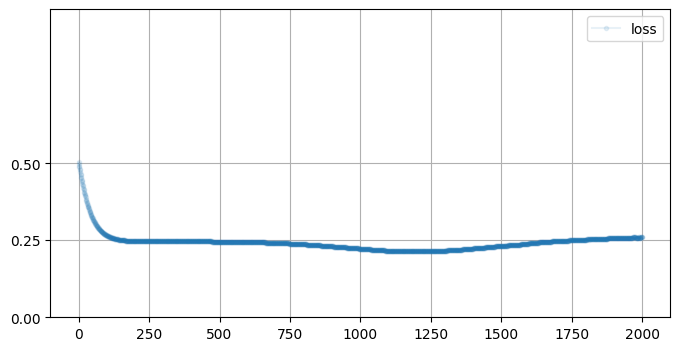

In [10]:
# D의 loss graph 확인
D.plot_progress()

D의 Loss 그래프에서 관찰가능한 사실  
loss는 0이되지 않고 (0.5)**2인 0.25주변에서 균형을 이룬다.  
로스가 떨어지는 750iter에서는 (ⅰ)G가 학습을 덜한 경우 (ⅱ)D가 잘 판단한 경우  
두가지 경우가 존재할 수 있음.  
2000iter에 가까워질수록 G가 D를 속일수 있는 데이터를 만들어 낸다는 의미로 해석 가능함.  


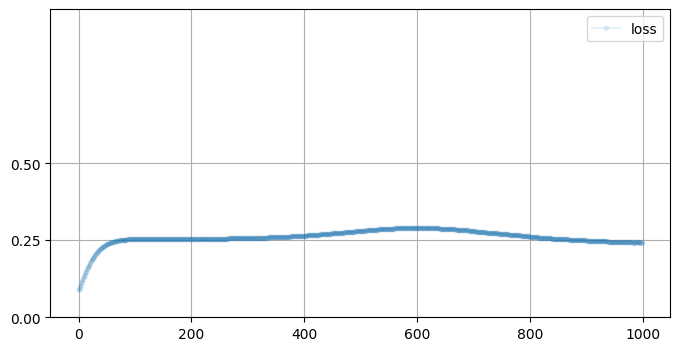

In [11]:
G.plot_progress()

In [12]:
# 학습 완료후 [1,0,1,0]에 가까운 패턴을 만들어 내는것을 확인가능함
G.forward(torch.Tensor([0.5])) 

tensor([0.8854, 0.0854, 0.9062, 0.0530], grad_fn=<SigmoidBackward0>)

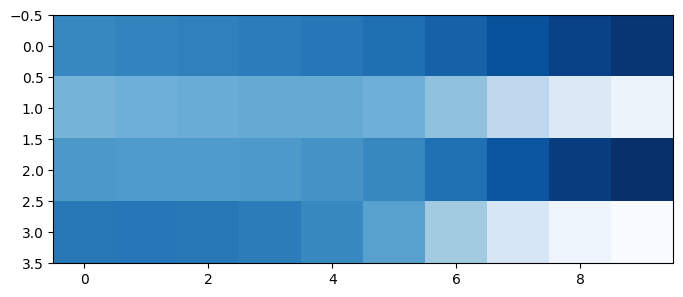

In [13]:
img_list # 트레이닝 과정 중 저장해둔 G 생성 샘플
plt.figure(figsize=(8,4))
plt.imshow(np.array(img_list).T, interpolation='none', cmap='Blues')

생성되어가는 데이터는 1000을 기준으로 점점 1010패턴이 뚜렷해지는 것을 확인가능함  
<span style="color:red"><b>생성기가 한번도 Real Sample을 본적이 없다는 사실을 주의깊게 기억해둘 것</b></span>

### 핵심정리  
* GAN 훈련시 다음의 순서를 맞춰서 개발해 나가는 것을 권장.  
    - 실제 데이터셋을 미리 살펴볼 것  
    - 판별기가 적어도 실제 데이터와 노이즈를 구분 가능한 성능인지 확인  
    - 훈련되지 않은 생성기가 올바른 형태의 데이터를 만들어 내는지 확인  
    - 손실이 어떻게 변하는지 시각화  
* 잘 훈련된 GAN은 loss가 중간값을 유지함 (ex) MSE의 경우 (0.5)**2 = 0.25  
* 생성기와 판별기를 따로 시각화, "생성기의 손실" == "생성된 데이터로 얻어진 판별기의 손실"  

## (CHAPTER7) 손으로 쓴 숫자 훈련

여기부터는 MNIST 데이터셋을 이용함

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

### 데이터셋 클래스

MnistDataset으로 진행함  

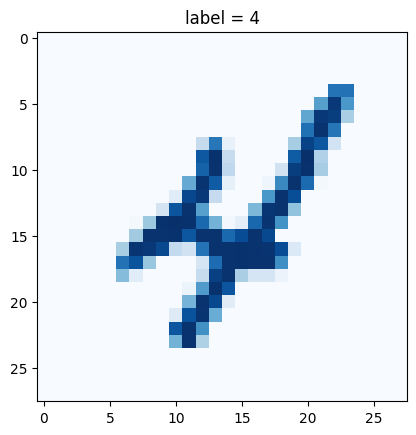

In [15]:
from dataset import MnistDataset
dataset = MnistDataset()
dataset.plot_image(9)

### MNIST 판별기

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # ⭐ 기존 모델에서 뉴런의 노드 개수만 변경
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0 # count epoch
        self.progress = [] # for appending loss
    

    def train(self, inputs, targets):
        """params update와 logging까지 같이 수행하는 함수

        Args:
            inputs (torch.Tensor): 데이터
            targets (torch.Tensor): 라벨
        """
        outputs = self.forward(inputs) # forward
        loss:torch.Tensor = self.loss_function(outputs, targets) # loss
        
        # appending loss
        self.counter += 1
        if  (self.counter % 10 == 0):
            self.progress.append(loss.item())
        # print info
        if (self.counter % 10000 == 0):
            print(f"counter = {self.counter}")
            

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(8,4), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))
    
    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
D = Discriminator() # new assign

for label, img, target in dataset:
    D.train(img, torch.FloatTensor([1.0]))
    D.train(generate_random(784), torch.FloatTensor([0.0]))

counter = 10000
counter = 20000
counter = 30000
counter = 40000
counter = 50000
counter = 60000
counter = 70000
counter = 80000
counter = 90000
counter = 100000
counter = 110000
counter = 120000


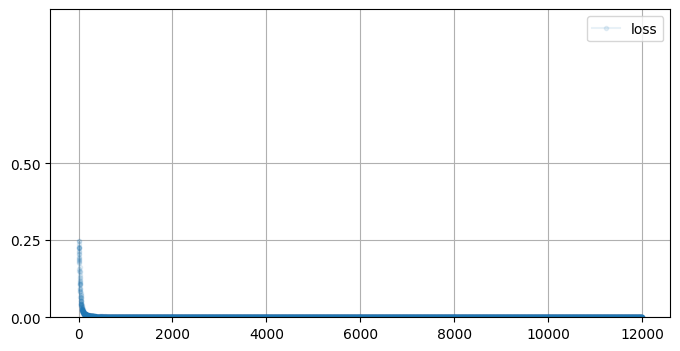

In [18]:
D.plot_progress() # 정상적인 로스하락 확인 가능

### 판별기 테스트하기

In [19]:
# D의 훈련상태 확인

for i in range(4):
    image_data_tensor = dataset[random.randint(0,60000)][1] # dataset은 list_slicing을 이용
    real_sample_loss = D.forward(image_data_tensor).item()
    print(real_sample_loss)
print('='*20)
for i in range(4):
    fake_sample_loss = D.forward(generate_random(784)).item()
    print(fake_sample_loss)

0.9943735599517822
0.9957102537155151
0.9954373240470886
0.9972795844078064
0.004755276720970869
0.005445892922580242
0.0056908936239778996
0.006677487399429083


### MNIST 생성기

앞에서 만든 "1010 패턴"과 다른점  
  "1010 패턴"의 경우 하나의 클래스만 가지고 있으므로 Seed를 고정함.  
  하지만 MNIST의 경우 다양한(10개) 클래스를 생성할 필요가 있음.  
  <b><span style="color:red">다시 말해, 트레인 샘플의 다양한 분포를 생성할 수 있어야 함.<b></span>

정확히 어떤 원리를 통해서 생성기가 작동하는지 알 수 없으나,  
생성기로 입력되는 조금씩 다른 숫자가 다양한 이미지를 생성하는데 도움을 줌.  
(ex) "0.0 ~ 0.2"사이의 seed는 3이라는 이미지를 생성. # latent vector  

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 200),
            nn.Sigmoid(),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0
        self.progress = []

    def forward(self, x):
        return self.model(x)

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=["loss"])
        df.plot(
            ylim=(0, 1.0),
            figsize=(8, 4),
            alpha=0.1,
            marker=".",
            grid=True,
            yticks=(0, 0.25, 0.5),
        )

    def train(self, D: Discriminator, inputs: torch.Tensor, targets: torch.Tensor):
        # 생성기 Fake 생성
        g_output = self.forward(inputs)

        # 판별기로 전달
        d_output = D.forward(g_output)

        # 오차 계산
        loss: torch.Tensor = D.loss_function(d_output, targets)

        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        # optimizer의 아규먼트에는 self(G)만 존재하므로, only 생성기 params 업데이트
        self.optimizer.step()

### 생성기 결과 확인하기

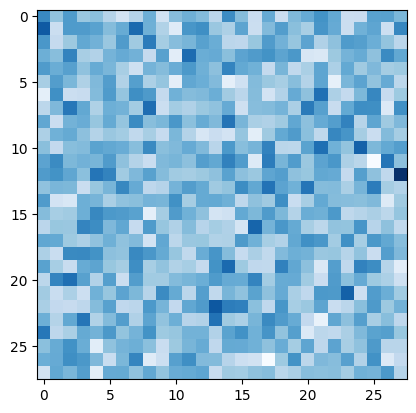

In [21]:
G = Generator() # new assign
output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28,28)
plt.imshow(img, interpolation='none', cmap='Blues')
# 무작위 노이즈, 만약 패턴이 있다면 그것은 운

### GAN 훈련하기

In [22]:
# 판별기 및 생성기 선언
D = Discriminator()
G = Generator()

mnist_datset = MnistDataset()
# 판별기와 생성기 훈련
for label, image_data_tensor, target_tensor in mnist_datset:
    
    # 판별기 실제 데이터 훈련
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # 거짓에 대한 판별기 훈련
    D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
    
    # 생성기 훈련
    G.train(D, generate_random(1), torch.FloatTensor([1.0]))

counter = 10000
counter = 20000
counter = 30000
counter = 40000
counter = 50000
counter = 60000
counter = 70000
counter = 80000
counter = 90000
counter = 100000
counter = 110000
counter = 120000


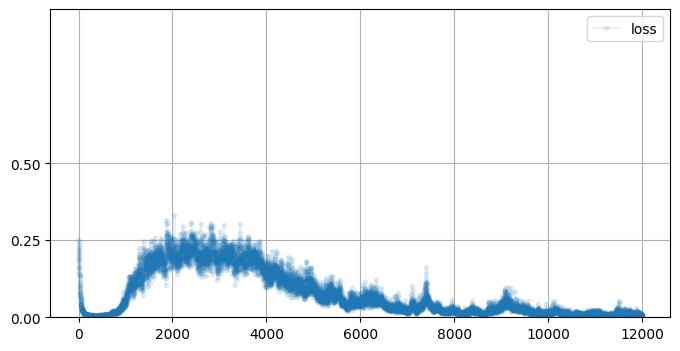

In [23]:
D.plot_progress()
# 0~3000 iter에는 G가 잘 속여 로스가 균형(0.25)을 맞춤
# 3000~12000 iter에는 판별기 loss가 0에 수렴, 더 이상 G가 만든 데이터에 속지 않음.

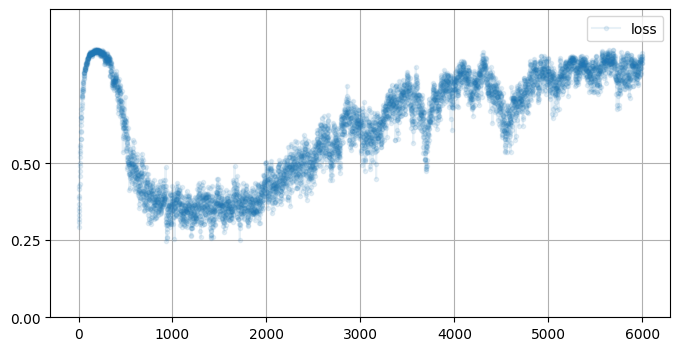

In [24]:
G.plot_progress()
# G의 loss가 ⬆️ == D가 잘 구분한다
# G의 loss가 ⬇️ == D가 잘 구분하지 못한다

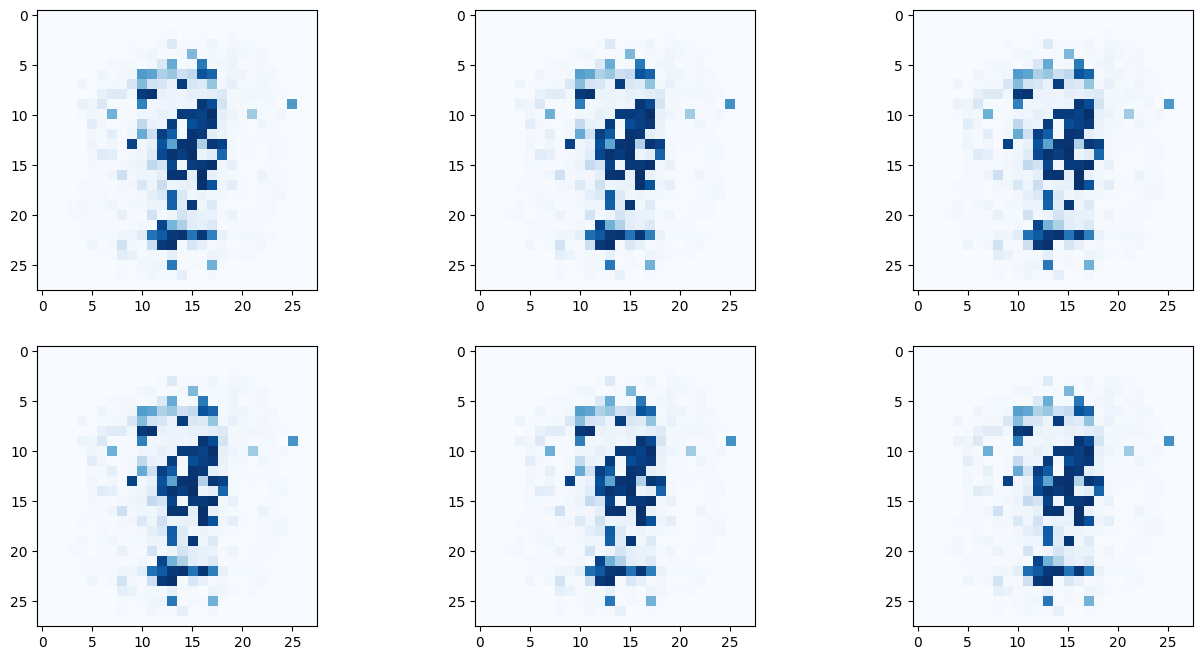

In [25]:
# 2행 3열 이미지 출력
f, axarr = plt.subplots(2, 3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28, 28)
        axarr[i, j].imshow(img, interpolation="none", cmap="Blues")

<b><span style="color:red">학습완료 후 관찰 사실</span></b>
* 어떤 형태를 확실히 가지고 있음. 
* 뭔가 다 비슷한 형태의 데이터를 생성함.

### 모드 붕괴

GAN을 훈련할 경우 빈번히 발생하는 문제가 모드 붕괴(mode collapse)  
일부의 데이터만을 생성자가 만드는 현상(문제)를 의미함.  
아직 명확하게 이해된 바는 없으나  
생성기가 판별기보다 앞서 훈련되어 '꿀 지점'을 찾는다고 하는 주장도 있음.  
이 현상을 완화시키기 위해서는 <b><span style="color:purple">"판별기를 생성기보다 조금 더 자주 훈련시키자"</span></b>  
라고 생각할 수 있으나 그렇지 않음.  
<b><span style="color:red">훈련의 양보다는 질이 중요</span></b>함.

![추가 설명](https://wandb.ai/authors/DCGAN-ndb-test/reports/Measuring-Mode-Collapse-in-GANs-Using-Weights-Biases--VmlldzoxNzg5MDk#what-is-mode-collapse?)
```
잘 훈련된 GAN은 다양한 결과물을 생성할 수 있습니다.  
사람의 얼굴 이미지를 생성할 때, 생성기가 다양한 특징을 가진 다양한 얼굴의 배치를 생성하기를 원할 것입니다.  
모드 붕괴는 제너레이터가 한 가지 유형의 출력 또는 작은 출력 세트만 생성할 수 있을 때 발생합니다.  
이는 생성기가 판별자를 쉽게 속일 수 있는 데이터 유형을 찾아내어 해당 한 가지 유형만 계속 생성하는 등  
훈련 과정에서 문제가 발생하기 때문에 발생할 수 있습니다.  
생성기가 다른 유형으로 전환할 인센티브가 없기 때문에 전체 시스템이 해당 한 가지 출력에 과도하게 최적화됩니다.  

모델 붕괴를 측정하는 올바른 방법은 없습니다.  
이미지를 수동으로 살펴보는 것과 같은 정성적 측정은 자명할 때만 효과가 있으며,  
더 복잡한 경우나 방대한 양의 데이터에서는 실패할 수 있습니다.  
IS(Inception Score) 또는 FID(Frechet Inception Distance)와 같은 다른 정량적 측정은  
특정 오브젝트 클래스 집합으로 사전 학습된 모델에 의존합니다.  
이러한 측정법에는 상한선이 없습니다(가설적으로 말하자면, 가능한 최고 점수는 무한대입니다).
```

### GAN 훈련 성능 향상하기  
`1️.` 로스함수 바꾸기  
    MSE → BCE  
    BCE가 더 Loss값도 크고, 분류문제에 더 적합한 함수임 # [Ref](https://www.youtube.com/watch?v=dFYrha09He4&t=150s)  
  
`2️.` 활성화 함수 바꾸기  
    중간레이어에 <code>LeakyReLU()</code>를 사용  
  
`3️.` 노말라이제이션 사용
    <code>LayerNorm()</code>을 사용  
  
`4️.` optimizer 변경  
    SGD를 Adam으로  
  
`5️.` 입력 시드의 차원 증가  
    1차원을 100차원으로  
    
`6.` 시드의 범위를 정규분포에서 추출
  
`7.` 에폭을 길게  


그리고 시드를 생성하는 방법을 바꿈  
* 판별기에 입력되는 Fake 이미지 값  
    0~1사이의 Random 분포, 정규분포와 같이 특정한 경향성을 띄면 안됨  
  
* <b><span style="color: red;">생성기에 입력되는 시드 값은 평균이 0이고 분산이 제한된 정규화된 값이 좋음</b></span>  
    (가중치 초기화와 관련되었다고 하는데... 정확히 이해가 되지는 않음...)

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            # nn.Sigmoid(),
            nn.LeakyReLU(0.02), # 2️⃣
            nn.LayerNorm(200), # 3️⃣
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # self.loss_function = nn.MSELoss()
        self.loss_function = nn.BCELoss() # 1️⃣
        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4) # 4️⃣
        self.counter = 0 # count epoch
        self.progress = [] # for appending loss
    

    def train(self, inputs, targets):
        """params update와 logging까지 같이 수행하는 함수

        Args:
            inputs (torch.Tensor): 데이터
            targets (torch.Tensor): 라벨
        """
        outputs = self.forward(inputs) # forward
        loss:torch.Tensor = self.loss_function(outputs, targets) # loss
        
        # appending loss
        self.counter += 1
        if  (self.counter % 10 == 0):
            self.progress.append(loss.item())
        # print info
        if (self.counter % 10000 == 0):
            print(f"counter = {self.counter}")
            

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=["loss"])
        df.plot(
            ylim=(0), # 범위 제한 삭제
            figsize=(8, 4), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0),
        )
    
    def forward(self, x):
        x = self.model(x)
        return x



class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 200),
            # nn.Sigmoid(),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        self.counter = 0
        self.progress = []

    def forward(self, x):
        return self.model(x)

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=["loss"])
        df.plot(
            ylim=(0), # 범위 제한 삭제
            figsize=(8, 4), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0),
        )

    def train(self, D: Discriminator, inputs: torch.Tensor, targets: torch.Tensor):
        # 생성기 Fake 생성
        g_output = self.forward(inputs)

        # 판별기로 전달
        d_output = D.forward(g_output)

        # 오차 계산
        loss: torch.Tensor = D.loss_function(d_output, targets)

        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        # optimizer의 아규먼트에는 self(G)만 존재하므로, only 생성기 params 업데이트
        self.optimizer.step()

In [33]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [29]:
'''
다시 훈련
'''

# 판별기 및 생성기 선언
D = Discriminator()
G = Generator()
EPOCHS = 3

mnist_datset = MnistDataset()
# 판별기와 생성기 훈련
for epoch in range(EPOCHS):
    for label, image_data_tensor, target_tensor in mnist_datset:
        
        # 판별기 실제 데이터 훈련
        D.train(image_data_tensor, torch.FloatTensor([1.0]))
        
        # 거짓에 대한 판별기 훈련
        D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
        
        # 생성기 훈련
        G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))
    print(f'{epoch}이 마무리되었습니다')

counter = 10000
counter = 20000
counter = 30000
counter = 40000
counter = 50000
counter = 60000
counter = 70000
counter = 80000
counter = 90000
counter = 100000
counter = 110000
counter = 120000
0이 마무리되었습니다
counter = 130000
counter = 140000
counter = 150000
counter = 160000
counter = 170000
counter = 180000
counter = 190000
counter = 200000
counter = 210000
counter = 220000
counter = 230000
counter = 240000
1이 마무리되었습니다
counter = 250000
counter = 260000
counter = 270000
counter = 280000
counter = 290000
counter = 300000
counter = 310000
counter = 320000
counter = 330000
counter = 340000
counter = 350000
counter = 360000
2이 마무리되었습니다


시드의 차원을 늘리고 분포에서 뽑아 입력함으로써  
모드 붕괴를 막음  

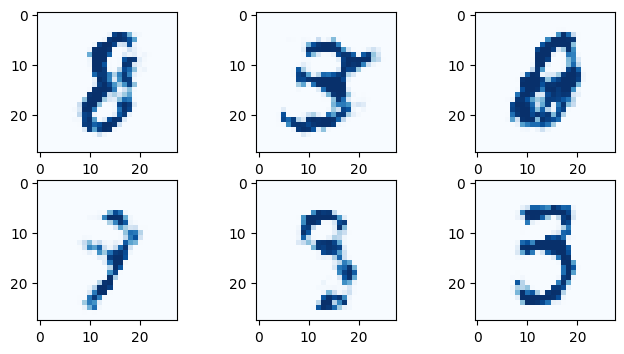

In [30]:
# 2행 3열 이미지 출력
f, axarr = plt.subplots(2, 3, figsize=(8,4))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28, 28)
        axarr[i, j].imshow(img, interpolation="none", cmap="Blues")

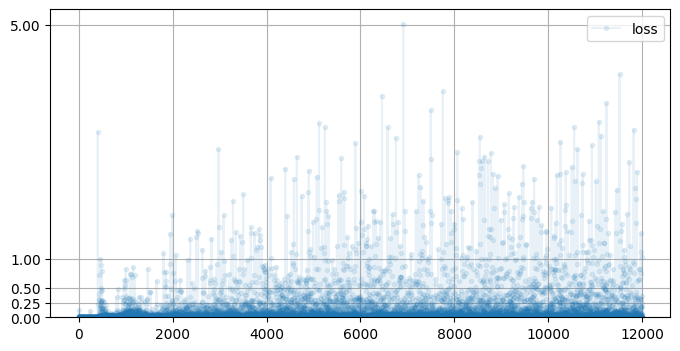

In [ ]:
D.plot_progress()

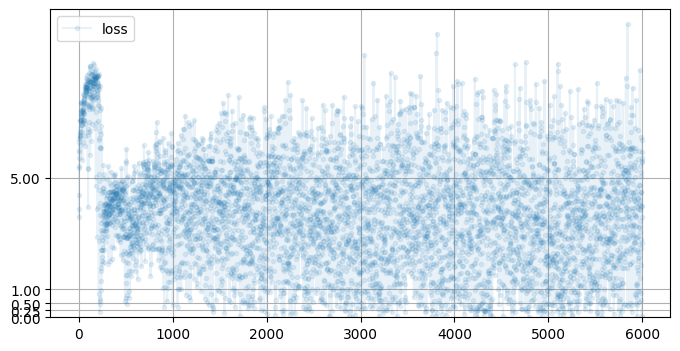

In [ ]:
G.plot_progress()

<b><span style="color:red">균형점에 도달했을경우 BCELoss()가 어떤 값을 가져야 할까?</span></b>  
최악의 경우는 ln(2)의 loss를 가지게 됨 # -(1 * ln(1/2))  
따라서 0.693인경우가 best임  

### 시드로 실험하기

<b><span style="color:red">시드를 두개 seed1, seed2를 이용해서 각자의 이미지를 생성하는 경우</span></b>   
seed1, seed2 사이의 seed는 어떤 이미지를 생성할까?  
만약 seed1과 seed2사이에 linspace를 하면 어떤 이미지들을 관찰할 수 있을까?


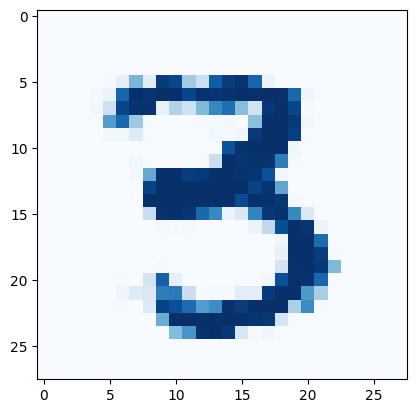

In [39]:
seed1 = generate_random_seed(100) # 좋은 이미지를 얻을때까지 반복해서 seed1를 찾음
out1:torch.Tensor = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation='none', cmap='Blues')

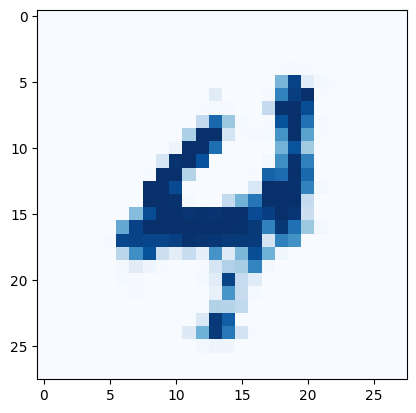

In [47]:
seed2 = generate_random_seed(100) # 좋은 이미지를 얻을때까지 반복해서 seed2를 찾음
out2:torch.Tensor = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28,28)
plt.imshow(img2, interpolation='none', cmap='Blues')

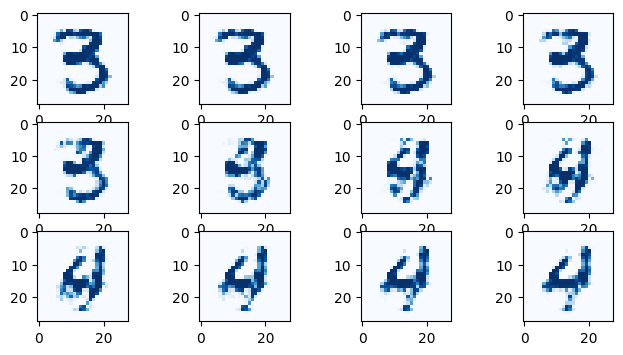

In [48]:
count = 0

# 2행 3열로 생성된 이미지 출력
f, axarr = plt.subplots(3, 4, figsize=(8,4))
for i in range(3): # row
    for j in range(4): # col
        seed = seed1 + (seed2 - seed1)/11 * count
        output:torch.Tensor = G.forward(seed)
        img = output.detach().numpy().reshape(28,28)
        axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
        count = count + 1

위의 결과와 같이 서서히 <code>seed1</code>에서 <code>seed2</code>를 향해  
형상이 변경되어감  
만약 시드를 더한다면 아래와 같이 둘을 합쳐진 이미지가 생성됨

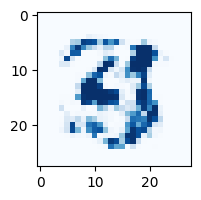

In [50]:
seed3 = seed1 + seed2
out3:torch.Tensor = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(img3, interpolation="none", cmap="Blues") # 둘을 합친 이미지가 생성됨

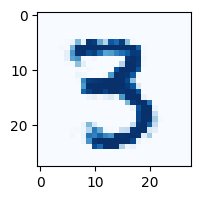

In [52]:
seed4 = seed1 - seed2
out4:torch.Tensor = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(img4, interpolation='none', cmap='Blues') 
# 직관과 달리 시드를 뺀다고해서 단순히 여집합 이미지가 만들어지지는 않음

### 핵심 정리

* MNIST 이미지 생성에서 픽셀의 spatial info가 없어도 GAN 메커니즘이 잘 동작함.  
* 모드 붕괴는 다른 선택지(=class)가 있어도 생성기가 하나의 클래스로만 숫자를 생성하는 현상을 의미함.
* 모드 붕괴의 원인과 해결방법은 아직까지 연구 중.(지금은 해결됬는지 모르겠음)
* GAN을 설계하기 가장 좋은 시작점은 서로 <span style='color:red'>같은 구조</span>로 만드는 것임.
* 대칭되도록 만드는 이유는 한쪽의 성능이 과하게 앞서나가는 것을 막기위해서임.  
* 훈련(training)은 양(epoch)보다 질(technique)이 더 중요.  
* 두 시드의 중간값 시드들은 중간정도로 보간된 이미지를 생성함.  
* 시드끼리 더한 시드는 두 이미지를 합친 형태가 생성됨
* 시드끼리 뺀 시드는 직관적인 패턴을 따르지 않음.  
* GAN에서 MSE의 경우 이상적인 오차는 0.25, BCE의 경우 ln(2)=0.69임.  

## (CHAPTER8) 얼굴 이미지

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

### 데이터 살펴보기

<code>celeba_make_hdf5.ipynb</code>를 이용, 이미지를 .h5py의 딕셔너리 형태의 데이터셋으로 생성함.  
\# 하지만 용량이 왜 늘어나는지 모르겠음.

img_align_celeba


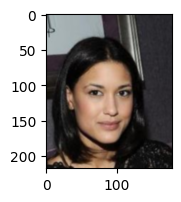

In [11]:
with h5py.File('./celeba_aligned_small.h5py', 'r') as file_object:
    for group in file_object:
        print(group) # img_align_celeba
        # 'img_align_celeba/'로 앞에서 묶었으므로 총 그룹은 1개로 생성됨,
        # group['filename']와 같이 dict방식으로 이미지에 접근 가능함.
        
    dataset = file_object['img_align_celeba'] # 일단 하위 그룹에 접근
    img = dataset['9.jpg'] # 하위 그룹에서 9.jpg이미지를 로딩
    plt.figure(figsize=(2,2))
    plt.imshow(img, interpolation='bicubic')

### 데이터셋 클래스

In [21]:
class CelebADataset(Dataset):
    def __init__(self, file:str):
        self.file_object = h5py.File(file,'r') # 멤버 변수로써 h5py 파일을 이용
        self.dataset = self.file_object['img_align_celeba']
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = np.array(self.dataset[f'{index}.jpg'])
        return torch.FloatTensor(img).cuda()/255.
    
    def plot_image(self, index):
        print(np.array(self.dataset[f'{index}.jpg']).shape)
        plt.imshow(np.array(self.dataset[f'{index}.jpg']), interpolation='nearest')

(218, 178, 3)


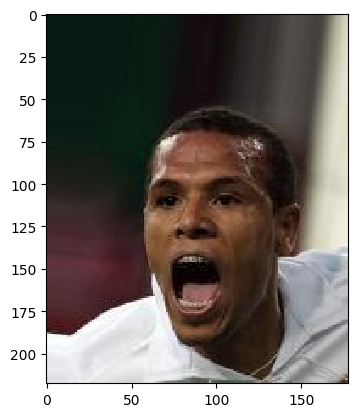

In [22]:
celeba_dataset = CelebADataset(file='./celeba_aligned_small.h5py')
celeba_dataset.plot_image(20)

### 판별기

입력 Node를 맞취주는 모듈인 View를 생성  
그 부분을 제외한 다른 동일하게 사용

In [47]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape, # 튜플로 바꿈(왜냐하면 *을 이용해서 flatten하기 위해)
        
    def forward(self, x:torch.Tensor):
        return x.view(*self.shape)

In [29]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            View(218*178*3), # 차원 flatten 모듈을 제일 앞에서 호출
            nn.Linear(218*178*3, 100),
            nn.LeakyReLU(),
            nn.LayerNorm(100),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        # self.loss_function = nn.MSELoss()
        self.loss_function = nn.BCELoss() # 1️⃣
        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4) # 4️⃣
        self.counter = 0 # count epoch
        self.progress = [] # for appending loss
    

    def train(self, inputs, targets):
        """params update와 logging까지 같이 수행하는 함수

        Args:
            inputs (torch.Tensor): 데이터
            targets (torch.Tensor): 라벨
        """
        outputs = self.forward(inputs) # forward
        loss:torch.Tensor = self.loss_function(outputs, targets) # loss
        
        # appending loss
        self.counter += 1
        if  (self.counter % 10 == 0):
            self.progress.append(loss.item())
        # print info
        if (self.counter % 10000 == 0):
            print(f"counter = {self.counter}")
            

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=["loss"])
        df.plot(
            ylim=(0), # 범위 제한 삭제
            figsize=(8, 4), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0),
        )
    
    def forward(self, x):
        x = self.model(x)
        return x

### 판별기 테스트하기

In [35]:
D = Discriminator().cuda()

for img_tensor in celeba_dataset:
    D.train(img_tensor, torch.FloatTensor([1.0]).cuda())
    D.train(generate_random_image((218,178,3)).cuda(), torch.FloatTensor([0.0]).cuda())
    # break

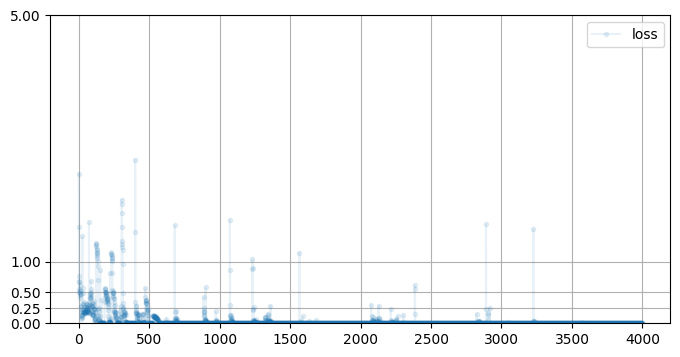

In [36]:
D.plot_progress() 
# 중간중간 튀기는 하지만 iter가 반복될수록 0에 확실히 수렴하는 것을 확인가능함

### 생성기

In [49]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential( 
            nn.Linear(100, 3*10*10), #  이 부분을 수정
            nn.LeakyReLU(0.02),
            nn.LayerNorm(3*10*10),
            nn.Linear(3*10*10, 3*218*178), # 이부분을 수정
            nn.Sigmoid(),
            View((218,178,3)) # 이부분을 수정
        )
        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        self.counter = 0
        self.progress = []

    def forward(self, x):
        return self.model(x)

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=["loss"])
        df.plot(
            ylim=(0), # 범위 제한 삭제
            figsize=(8, 4), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0),
        )

    def train(self, D: Discriminator, inputs: torch.Tensor, targets: torch.Tensor):
        # 생성기 Fake 생성
        g_output = self.forward(inputs)

        # 판별기로 전달
        d_output = D.forward(g_output)

        # 오차 계산
        loss: torch.Tensor = D.loss_function(d_output, targets)

        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        # optimizer의 아규먼트에는 self(G)만 존재하므로, only 생성기 params 업데이트
        self.optimizer.step()

### 생성기 결과 확인하기

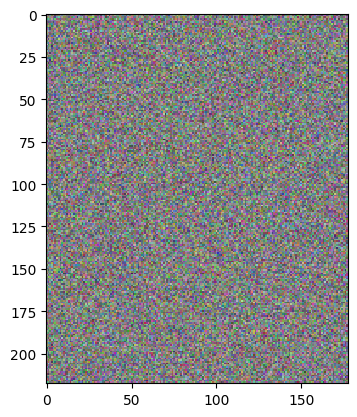

In [54]:
G = Generator().cuda()

output = G.forward(generate_random_seed(100).cuda()) # GPU 계산
img = output.detach().cpu().numpy() # output GPU --> CPU
plt.imshow(img, interpolation='none', cmap='Blues')

### GAN 훈련하기

In [59]:
D = Discriminator().cuda()
G = Generator().cuda()

EPOCHS = 1

for epoch in range(EPOCHS):
    print(f'epoch = {epoch+1}')
    
    for img_data_tensor in celeba_dataset:
        # 참에 대해 "판별기" 훈련
        D.train(img_data_tensor.cuda(), torch.FloatTensor([1.0]).cuda())
        # 거짓에 대해서 "판별기" 훈련
        D.train(
            G.forward(generate_random_seed(100).cuda()).detach().cuda(),
            torch.FloatTensor([0.0]).cuda()
        )
        
        # 생성기 훈련
        G.train(
            D,
            generate_random_seed(100).cuda(),
            torch.FloatTensor([1.0]).cuda()
        )

epoch = 1
counter = 10000
counter = 20000
counter = 30000
counter = 40000


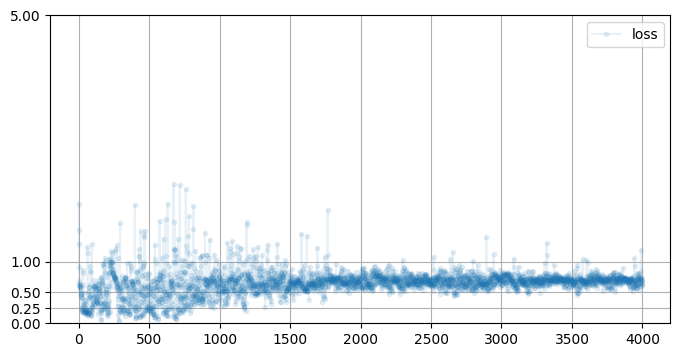

In [60]:
D.plot_progress() # 로스가 ln(2)=0.67로 정상적으로 흐름

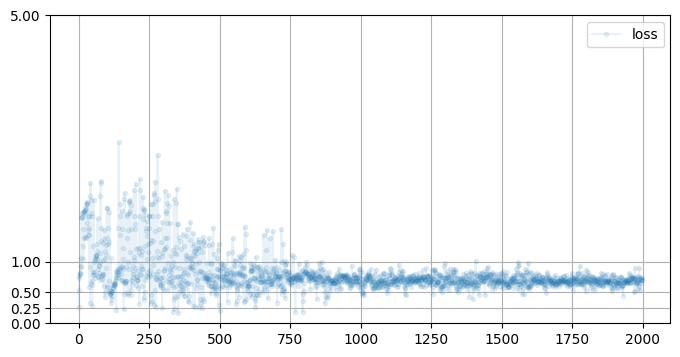

In [61]:
G.plot_progress() # 로스가 ln(2)=0.67로 정상적으로 흐름

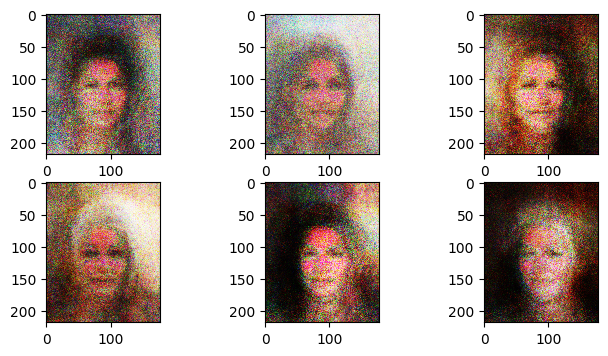

In [63]:
f, axarr = plt.subplots(2, 3, figsize=(8,4))

for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100).cuda())
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

얼추 비슷하게는 보임.  
이 훈련 과정에서 <span style='color:red'><b>Generator가 학습한 것은 likelihood</b></span>임.

### 핵심 정리

* 데이터를 열고 닫는 과정은 클라우드 환경에서는 비효율적임.  
* 랜덤 액세스를 특화된 형식으로 데이터 리패키징하는것이 좋은 구현방식임.  
* 책에서는 HDF를 추천하며, 이를 이용하면 효과적으로 파일 핸들링 가능함.  
* GAN은 훈련 데이터를 기억하지 않음.  
* GAN은 훈련 데이터의 <span style='color:red'>확률분포(probability distribution)을 파악하고 이를 재현하는 과정</span>을 학습함.